In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statistics as st 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

# EDA

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### planning_area & subzone NA value in test dataset

In [3]:
emptyPA = test[test['planning_area'].isna()]
emptyPA['address'].unique()

array(['1 tessensohn road', '38 lorong 32 geylang', '17 farrer drive',
       '5 jalan mutiara'], dtype=object)

In [4]:
missingPA = pd.read_csv('auxiliary-data/missingPAdata.csv')
missingPA.head()

,address,planning_area,subzone
0,1 tessensohn road,kallang,boon keng
1,38 lorong 32 geylang,geyland,aljunied
2,15 farrer drive,tanglin,chatsworth
3,17 farrer drive,tanglin,chatsworth
4,5 jalan mutiara,tanglin,nassim


In [5]:
s = missingPA.set_index('address')['planning_area']
test['planning_area']=test['planning_area'].fillna(test['address'].map(s))

In [6]:
s = missingPA.set_index('address')['subzone']
test['subzone']=test['planning_area'].fillna(test['subzone'].map(s))

#### planning & subzone in train dataset

In [7]:
data = train[train['planning_area'].isna()]
data['address'].unique()

array(['1 tessensohn road', '15 farrer drive', '17 farrer drive',
       '38 lorong 32 geylang', '5 jalan mutiara'], dtype=object)

In [8]:
s = missingPA.set_index('address')['planning_area']
train['planning_area']=train['planning_area'].fillna(train['address'].map(s))

In [9]:
s = missingPA.set_index('address')['subzone']
train['subzone']=train['planning_area'].fillna(train['subzone'].map(s))

## Pre-processing

### Remove listing_id  
#### listing_id is all unique without duplicates

In [10]:
train = train.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])
test = test.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])

# train = train.drop(columns=['property_details_url', 'elevation','property_name','address','title'])

In [11]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,price
count,19332.000000,20174.000000,19820.000000,2.025400e+04,14602.000000,20254.000000,20254.000000,2.025400e+04
mean,2010.833695,3.122931,2.643542,1.854364e+03,376.253938,1.434282,103.855356,5.228263e+06
std,15.822803,1.281658,1.473835,1.354343e+04,346.882474,1.558472,3.593441,2.779748e+08
min,1963.000000,1.000000,1.000000,0.000000e+00,4.000000,1.239621,-77.065364,0.000000e+00
25%,2000.000000,2.000000,2.000000,8.070000e+02,106.000000,1.307329,103.806576,8.190000e+05
50%,2017.000000,3.000000,2.000000,1.119000e+03,296.000000,1.329266,103.841552,1.680000e+06
75%,2023.000000,4.000000,3.000000,1.528000e+03,561.000000,1.372461,103.881514,3.242400e+06
max,2028.000000,10.000000,10.000000,1.496000e+06,2612.000000,69.486768,121.023232,3.924243e+10


### Adding Distances

#### Add distance to commericial centres

In [12]:
ccdistance = pd.read_csv('auxiliary-data/sg-commerical-centres.csv')

In [13]:
# vectorized haversine function
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [14]:
# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(train, ccdistance, on = 'planning_area')
expected_result.head()
train['cc_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(test, ccdistance, on = 'planning_area')
expected_result.head()
test['cc_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [15]:
ccdistancemean = train['cc_distance'].median()
train['cc_distance']=train['cc_distance'].fillna(ccdistancemean)

ccdistancemean = test['cc_distance'].median()
test['cc_distance']=test['cc_distance'].fillna(ccdistancemean)

#### Add distance to mrt stations

In [16]:
# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(train, mrtdistance, on = 'planning_area')
train['mrt_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])


# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(test, mrtdistance, on = 'planning_area')
test['mrt_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [17]:
mrtdistancemedian = train['mrt_distance'].median()
train['mrt_distance']=train['mrt_distance'].fillna(mrtdistancemedian)

mrtdistancemedian = test['mrt_distance'].median()
test['mrt_distance']=test['mrt_distance'].fillna(mrtdistancemedian)

#### Add distance to primary school 

In [18]:
# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(train, primaryschooldistance, on = 'planning_area')
train['primary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(test, primaryschooldistance, on = 'planning_area')
test['primary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [19]:
pschoolmedian = train['primary_school_distance'].median()
train['primary_school_distance'] = train['primary_school_distance'].fillna(pschoolmedian)

pschoolmedian = test['primary_school_distance'].median()
test['primary_school_distance'] = test['primary_school_distance'].fillna(pschoolmedian)

#### Add distance to secondary school

In [20]:
# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['secondary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['secondary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [21]:
sschooldistance = train['secondary_school_distance'].median()
train['secondary_school_distance'] = train['secondary_school_distance'].fillna(sschooldistance)

sschooldistance = test['secondary_school_distance'].median()
test['secondary_school_distance'] = test['secondary_school_distance'].fillna(sschooldistance)

#### Add distance to shopping malls

In [22]:
# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['shop_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['shop_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [23]:
sdistancemedian = train['shop_distance'].median()
train['shop_distance'] = train['shop_distance'].fillna(sdistancemedian)

sdistancemedian = test['shop_distance'].median()
test['shop_distance'] = test['shop_distance'].fillna(sdistancemedian)

In [24]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,1.414399,103.837196,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,1.372597,103.875625,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,1.298773,103.895798,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,1.312364,103.803271,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,1.273959,103.843635,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600


### lng & lat

In [25]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,1.414399,103.837196,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,1.372597,103.875625,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,1.298773,103.895798,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,1.312364,103.803271,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,1.273959,103.843635,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600


In [26]:
train = train.drop(columns=['lat','lng'])

In [27]:
test = test.drop(columns=['lat','lng'])

### Population

In [28]:
population = pd.read_csv('auxiliary-data/sg-subzones.csv')

In [29]:
expected_result = pd.merge(train, population, on = 'planning_area')
train['population'] = expected_result['population']
train['area_size'] = expected_result['area_size']

In [30]:
expected_result = pd.merge(test, population, on = 'planning_area')
test['population'] = expected_result['population']
test['area_size'] = expected_result['area_size']

In [31]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


### Property Type cleaning

In [32]:
#Change all to uppercase
train['property_type']=train['property_type'].str.upper()

#Change all to uppercase
test['property_type']=test['property_type'].str.upper()

In [33]:
#for regression only
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(train['property_type'])
# train['property_type']=le.transform(train['property_type'])

# test['property_type']=le.transform(test['property_type'])

# one hot endcoding
# pd.get_dummies(train.property_type, prefix='property')

### Tenure 

In [34]:
train['tenure'] = train['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

train['tenure'] = train['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    ],
    '999-year leasehold'
)



test['tenure'] = test['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

test['tenure'] = test['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    ],
    '999-year leasehold'
)

In [35]:
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [36]:
train['tenure'] = train['tenure'].fillna('99-year leasehold')

In [37]:
## Remove NA 
train = train.dropna(subset=['tenure'])

## Remove NA 
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [38]:
#for regression only

# from sklearn import preprocessing
# tenurepp = preprocessing.LabelEncoder()
# tenurepp.fit(train['tenure'])
# train['tenure']=tenurepp.transform(train['tenure'])

# test['tenure']=tenurepp.transform(test['tenure'])

### Funishing

In [39]:
#Assume not specified and na as unfurnished 
train['furnishing'] = train['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

#Assume not specified and na as unfurnished 
test['furnishing'] = test['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

In [40]:
#for regression only

# from sklearn import preprocessing
# furnishing = preprocessing.LabelEncoder()
# furnishing.fit(train['furnishing'])
# train['furnishing']=furnishing.transform(train['furnishing'])

# test['furnishing']=furnishing.transform(test['furnishing'])

### floor_level 

In [41]:
# Too few data for floor level, we should just take out the column
train = train.drop(columns='floor_level')

# Too few data for floor level, we should just take out the column
test = test.drop(columns='floor_level')

### total_num_units

In [42]:
mediantotalunit = train['total_num_units'].median()
train['total_num_units'].fillna(mediantotalunit, inplace=True)

mediantotalunit = test['total_num_units'].median()
test['total_num_units'].fillna(mediantotalunit, inplace=True)

### build year

In [43]:
avgbuildyear = round(train['built_year'].median(),0)
train['built_year'] = train['built_year'].fillna(avgbuildyear)

avgbuildyear = round(test['built_year'].median(),0)
test['built_year'] = test['built_year'].fillna(avgbuildyear)

### num_baths

In [44]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,HDB 4 ROOMS,99-year leasehold,1988.0,3.0,2.0,1115,unfurnished,NaN,116.0,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,HDB,99-year leasehold,1992.0,4.0,2.0,1575,unfurnished,"1, 2, 3, 4, 5, 6 br",296.0,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055
2,CONDO,freehold,2022.0,4.0,6.0,3070,partial,"studio, 3, 4, 5, 6 br",56.0,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,CONDO,freehold,2023.0,3.0,2.0,958,partial,"studio, 1, 2, 3, 4 br",638.0,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,CONDO,99-year leasehold,2026.0,2.0,1.0,732,unfurnished,"studio, 1, 2, 3, 4, 5 br",351.0,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


In [45]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types          object
total_num_units              float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
dtype: object

In [46]:
a = train[train['num_baths'].isna()]
a[a['num_beds'].isna()]

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
3713,BUNGALOW,freehold,1990.0,NaN,NaN,9594,unfurnished,"studio, 1, 4, 5, 6, 7 br",296.0,novena,novena,16275000.0,5.668353,5.872226,6.905858,11.134265,11.134265,2620,0.4364
4691,CONDO,99-year leasehold,2023.0,NaN,NaN,431,unfurnished,"studio, 1, 2, 3, 4, 5, 8 br",774.0,outram,outram,1222200.0,5.825357,8.355056,11.798265,15.372730,15.372730,890,2.2068
4939,HDB,99-year leasehold,1980.0,NaN,NaN,731,unfurnished,NaN,112.0,bedok,bedok,367500.0,15.229001,7.025831,8.583307,13.354867,13.354867,42240,1.3402
5002,HDB,99-year leasehold,2004.0,NaN,NaN,1184,unfurnished,NaN,90.0,punggol,punggol,669900.0,16.664632,6.751215,7.404180,7.477411,7.477411,42240,1.3402
11500,HDB,99-year leasehold,1985.0,NaN,NaN,786,unfurnished,"studio, 2, 3, 4 br",296.0,bukit batok,bukit batok,409500.0,8.707527,4.914059,6.279880,18.454836,18.454836,24760,1.0619


In [47]:
avgbath = train['num_baths'].median()
train['num_baths'] = train['num_baths'].fillna(avgbath)

avgbath = test['num_baths'].median()
test['num_baths'] = test['num_baths'].fillna(avgbath)

### num_bedds

In [48]:
avgbed = train['num_beds'].median()
train['num_beds'] = train['num_beds'].fillna(avgbath)

avgbed = test['num_beds'].median()
test['num_beds'] = test['num_beds'].fillna(avgbath)

### num_avaliable_units

In [49]:
numavaunittypes = train.available_unit_types.str.count(',') + 1
train['available_unit_types'] = numavaunittypes

In [50]:
avg_ava_units = train['available_unit_types'].median()
train['available_unit_types'] = train['available_unit_types'].fillna(avg_ava_units)

In [51]:
numavaunittypes = test.available_unit_types.str.count(',') +1
test['available_unit_types'] = numavaunittypes

avg_ava_units = test['available_unit_types'].median()
test['available_unit_types'] = test['available_unit_types'].fillna(avg_ava_units)

In [52]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types         float64
total_num_units              float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
dtype: object

### Subzone & planning zone Encoding

In [53]:
#regression 

# pa = train['planning_area'] + test['planning_area']
# pa = pa.dropna().drop_duplicates().unique()
# pa = pd.DataFrame(pa)
# pa.count()

In [54]:
# a = train['planning_area'].drop_duplicates()
# b = test['planning_area'].drop_duplicates()
# c = pd.concat([a, b]).dropna()
# c = c.drop_duplicates()

In [55]:
# #for regression only

# from sklearn import preprocessing
# planningzone = preprocessing.LabelEncoder()
# planningzone.fit(c)

# train = train.dropna()
# train['planning_area']=planningzone.transform(train['planning_area'])

In [56]:
# mostfreq = test['planning_area'].mode()
# mostfreq
# test['planning_area'] = test['planning_area'].fillna('bukit timah')
# test['planning_area']=planningzone.transform(test['planning_area'])

### size_sqft

In [57]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,HDB 4 ROOMS,99-year leasehold,1988.0,3.0,2.0,1115,unfurnished,5.0,116.0,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,HDB,99-year leasehold,1992.0,4.0,2.0,1575,unfurnished,6.0,296.0,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055
2,CONDO,freehold,2022.0,4.0,6.0,3070,partial,5.0,56.0,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,CONDO,freehold,2023.0,3.0,2.0,958,partial,5.0,638.0,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,CONDO,99-year leasehold,2026.0,2.0,1.0,732,unfurnished,6.0,351.0,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


In [58]:
train = train[train['size_sqft'] != 0]

#### price 

Remove price which is 0

In [59]:
train = train[train['price'] != 0]

## Change Types

In [60]:
train['built_year'] = train['built_year'].astype(int)
train['num_beds'] = train['num_beds'].astype(int)
train['num_baths'] = train['num_baths'].astype(int)
train['available_unit_types'] = train['available_unit_types'].astype(int)
train['total_num_units'] = train['total_num_units'].astype(int)

In [61]:
train.count()

property_type                20153
tenure                       20153
built_year                   20153
num_beds                     20153
num_baths                    20153
size_sqft                    20153
furnishing                   20153
available_unit_types         20153
total_num_units              20153
subzone                      20153
planning_area                20153
price                        20153
cc_distance                  20153
mrt_distance                 20153
primary_school_distance      20153
secondary_school_distance    20153
shop_distance                20153
population                   20153
area_size                    20153
dtype: int64

In [62]:
test['built_year'] = test['built_year'].astype(int)
test['num_beds'] = test['num_beds'].astype(int)
test['num_baths'] = test['num_baths'].astype(int)
test['available_unit_types'] = test['available_unit_types'].astype(int)
test['total_num_units'] = test['total_num_units'].astype(int)

In [63]:
test.count()

property_type                7000
tenure                       7000
built_year                   7000
num_beds                     7000
num_baths                    7000
size_sqft                    7000
furnishing                   7000
available_unit_types         7000
total_num_units              7000
subzone                      7000
planning_area                7000
cc_distance                  7000
mrt_distance                 7000
primary_school_distance      7000
secondary_school_distance    7000
shop_distance                7000
population                   7000
area_size                    7000
dtype: int64

## Outlier Detection

#### Price Per Sqft

In [64]:
# medain_sqft = train['size_sqft'].median()
# train['size_sqft'] = train['size_sqft'].fillna(medain_sqft)

In [65]:
price_per_sqft = train['price']/train['size_sqft'] 
train['price_per_sqft'] = price_per_sqft

In [66]:
medain_psqft = train['price_per_sqft'].median()
train['price_per_sqft'] = train['price_per_sqft'].fillna(medain_psqft)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

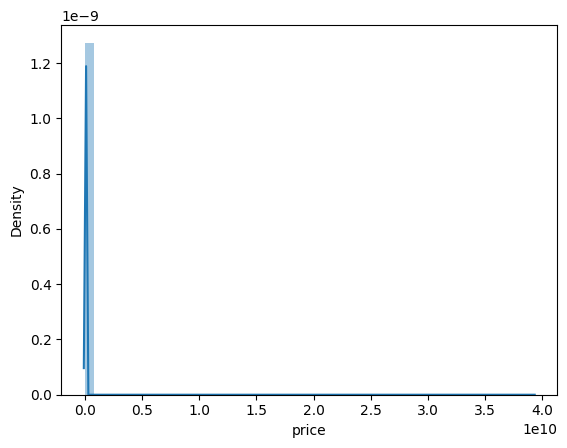

In [67]:
sns.distplot(train['price'])

In [68]:
train['log_price']= np.log(train['price'])

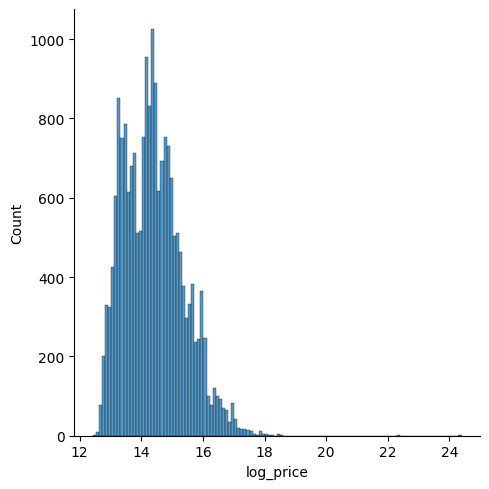

In [69]:
sns.displot(train['log_price'])

#### Coorleation Matrix Before Outlier removal

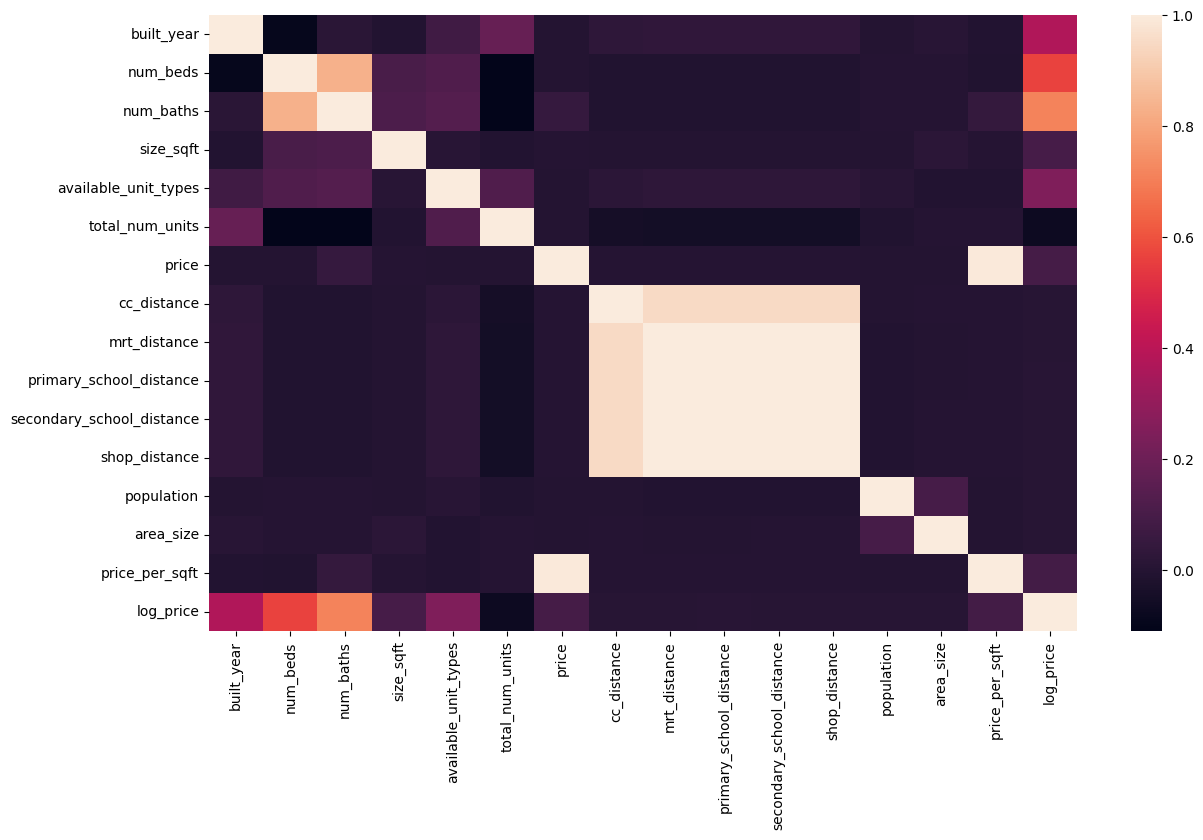

In [70]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr())
plt.show()

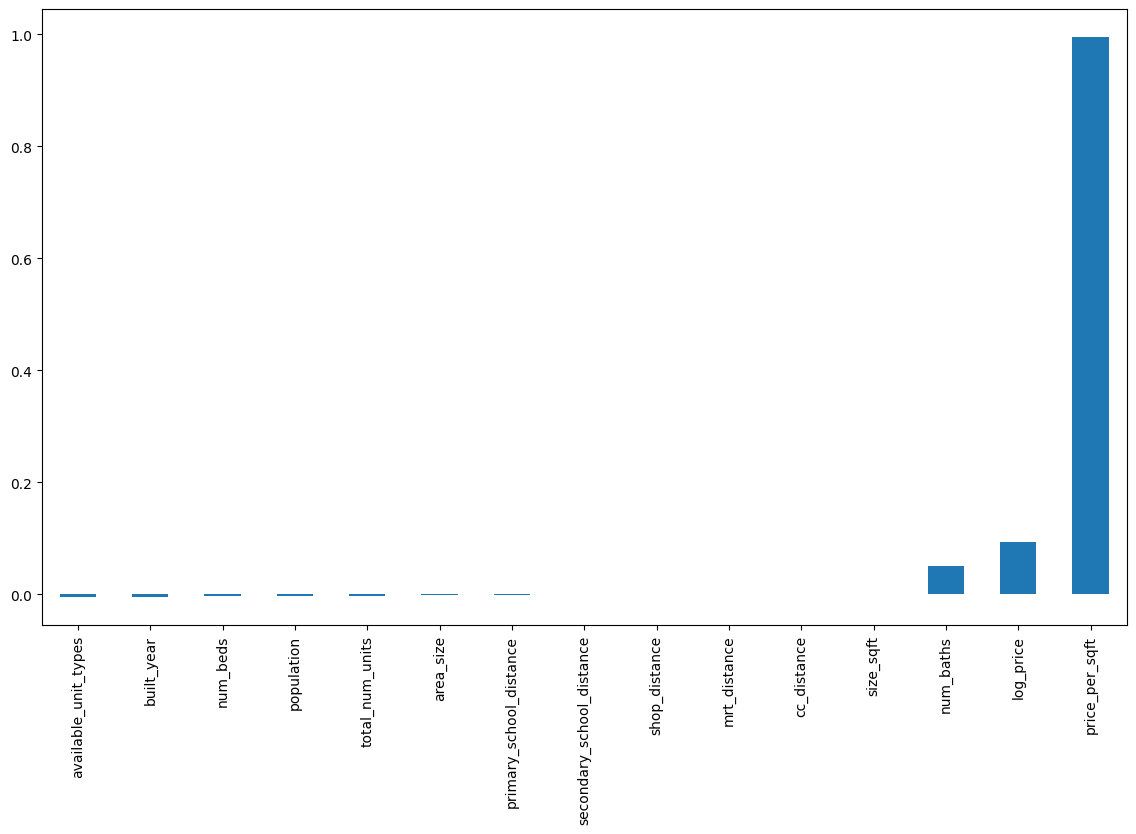

In [71]:
plt.figure(figsize=(14,8))
train.corr()['price'].sort_values()[:-1].plot(kind='bar')
plt.show()

#### Isolation Forest on Price, Price per Sqft, cc_distance, mrt distance, primary school distance, secondary school distance, shop distance

In [72]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,...,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,log_price
0,HDB 4 ROOMS,99-year leasehold,1988,3,2,1115,unfurnished,5,116,yishun,...,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329,461.434978,13.150951
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,serangoon,...,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055,632.000000,13.810900
2,CONDO,freehold,2022,4,6,3070,partial,5,56,marine parade,...,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,2763.843648,15.953810
3,CONDO,freehold,2023,3,2,958,partial,5,638,bukit timah,...,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,2741.127349,14.780972
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,downtown core,...,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,2409.836066,14.383095


In [73]:
outlierdata = train[['log_price','price_per_sqft','cc_distance','mrt_distance','primary_school_distance','secondary_school_distance','shop_distance']]

In [74]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(max_samples='auto', contamination=float(0.08))
model.fit(outlierdata)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.08)

In [75]:
train['scores_price']=model.decision_function(outlierdata)
train['anomaly_price']=model.predict(outlierdata)

In [76]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,...,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,log_price,scores_price,anomaly_price
0,HDB 4 ROOMS,99-year leasehold,1988,3,2,1115,unfurnished,5,116,yishun,...,1.689357,5.178683,2.538065,2.538065,10250,1.4329,461.434978,13.150951,-0.025282,-1
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,serangoon,...,6.871207,8.310177,6.710202,6.710202,18660,8.4055,632.000000,13.810900,0.059950,1
2,CONDO,freehold,2022,4,6,3070,partial,5,56,marine parade,...,13.983476,9.485153,15.197137,15.197137,890,2.2068,2763.843648,15.953810,0.049171,1
3,CONDO,freehold,2023,3,2,958,partial,5,638,bukit timah,...,13.479646,3.290085,12.950660,12.950660,28000,1.5110,2741.127349,14.780972,0.075839,1
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,downtown core,...,15.981982,13.818954,17.977600,17.977600,4370,2.2092,2409.836066,14.383095,0.040064,1


In [77]:
anomaly=train.loc[train['anomaly_price']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

      property_type             tenure  built_year  num_beds  num_baths  \
0       HDB 4 ROOMS  99-year leasehold        1988         3          2   
18            CONDO  99-year leasehold        2017         4          7   
30        APARTMENT           freehold        2023         3          3   
35      HDB 4 ROOMS  99-year leasehold        2017         3          2   
48              HDB  99-year leasehold        2018         3          2   
...             ...                ...         ...       ...        ...   
20205         CONDO  99-year leasehold        2023         1          1   
20221      BUNGALOW  99-year leasehold        1977         5          4   
20235         CONDO  99-year leasehold        2027         2          1   
20236   HDB 5 ROOMS  99-year leasehold        1996         4          2   
20243   HDB 2 ROOMS  99-year leasehold        1976         2          1   

       size_sqft   furnishing  available_unit_types  total_num_units  \
0           1115  unfurnish

In [78]:
train = train[train.anomaly_price != -1]

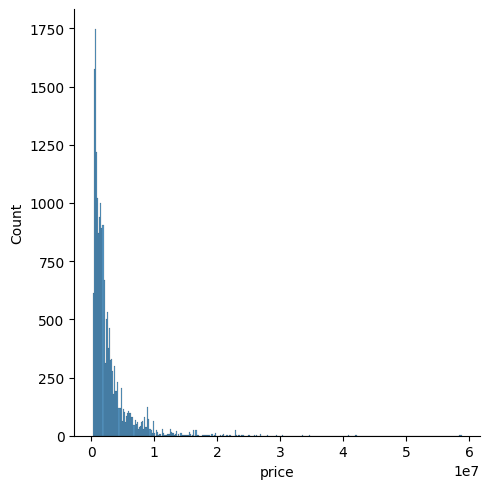

In [79]:
sns.displot(train['price'])

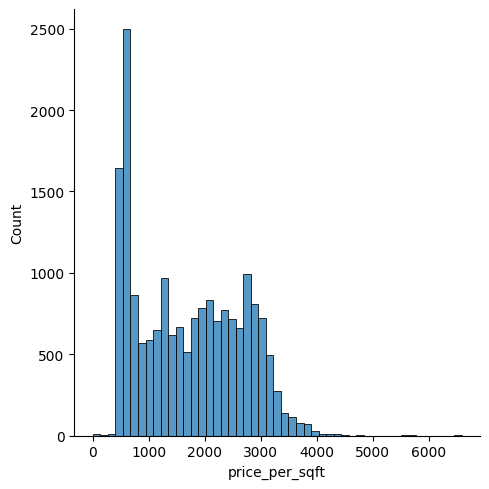

In [80]:
sns.displot(train['price_per_sqft'])

In [81]:
print("Skewness : %f" % train['price'].skew())
print("Kurtosis : %f" % train['price'].kurt())

Skewness : 3.982592
Kurtosis : 30.169109


In [82]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,available_unit_types,total_num_units,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,log_price,scores_price,anomaly_price
count,18540.000000,18540.000000,18540.000000,1.854000e+04,18540.000000,18540.000000,1.854000e+04,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.0
mean,2011.562999,3.065264,2.562945,1.747449e+03,4.721359,361.546710,2.631254e+06,10.298632,8.703711,10.982043,9.687485,9.687485,17070.980583,1.794979,1707.598336,14.364246,0.065107,1.0
std,15.374687,1.242899,1.391442,1.409815e+04,1.687274,297.504167,3.048773e+06,4.654233,4.535822,5.176569,4.343343,4.343343,16224.927127,1.528548,936.740306,0.881245,0.026242,0.0
min,1963.000000,1.000000,1.000000,9.200000e+01,1.000000,4.000000,2.508000e+05,0.166654,0.027288,0.163496,0.097494,0.097494,0.000000,0.436400,1.049958,12.432411,0.000005,1.0
25%,2002.000000,2.000000,2.000000,7.970000e+02,4.000000,160.000000,8.400000e+05,6.971968,5.050721,7.091899,6.222268,6.222268,4370.000000,1.061900,731.442614,13.641157,0.047337,1.0
50%,2017.000000,3.000000,2.000000,1.108000e+03,5.000000,296.000000,1.674700e+06,10.324064,8.258901,10.904891,9.605643,9.605643,10840.000000,1.432900,1668.625197,14.331145,0.068387,1.0
75%,2023.000000,4.000000,3.000000,1.475000e+03,6.000000,455.000000,3.087525e+06,12.922543,12.166360,14.765006,13.172567,13.172567,24760.000000,2.206800,2511.403657,14.942880,0.085240,1.0
max,2028.000000,10.000000,10.000000,1.496000e+06,10.000000,2612.000000,5.880000e+07,29.798731,22.877877,29.078982,22.989355,22.989355,60670.000000,8.405500,6585.123967,17.889652,0.122727,1.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


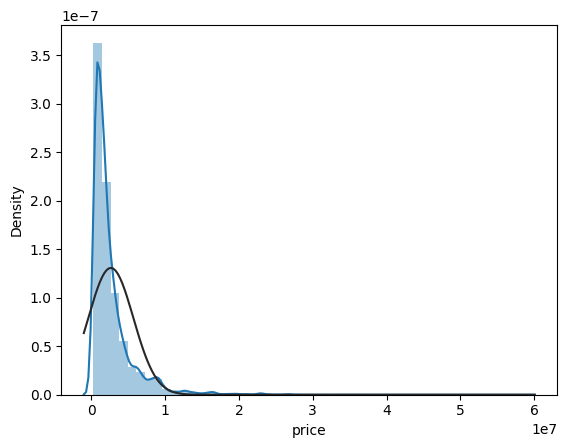

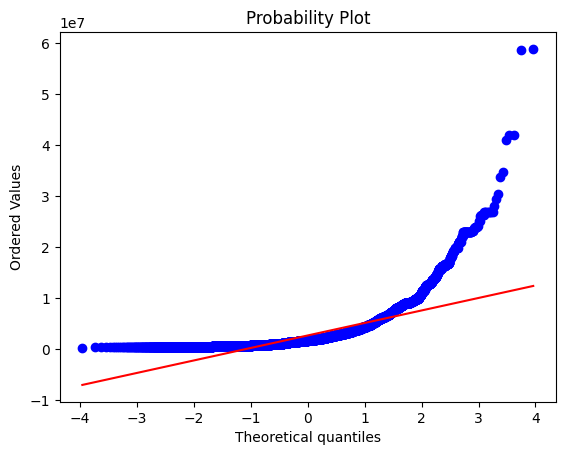

In [83]:
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler


sns.distplot(train['price'], fit = norm)
fig = plt.figure()
res = stats.probplot(train['price'],plot = plt)

In [84]:
train = train.drop(columns='scores_price')
train = train.drop(columns='anomaly_price')

In [85]:
test.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,planning_area,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,CONDO,freehold,2022,1,1,463,unfurnished,6,250,serangoon,serangoon,1.046868,0.960436,13.993735,1.853769,1.853769,8490,1.1801
1,CONDO,99-year leasehold,2017,3,3,1033,unfurnished,6,463,pasir ris,pasir ris,8.581574,9.346690,13.709624,8.403509,8.403509,14700,2.3307
2,CONDO,99-year leasehold,2007,1,1,570,fully,4,646,museum,museum,6.755363,6.710905,8.965840,6.503082,6.503082,24760,1.0619
3,HDB,99-year leasehold,2017,3,2,1216,unfurnished,5,968,choa chu kang,choa chu kang,14.229296,14.293216,12.559347,13.963584,13.963584,36080,3.0232
4,HDB 4 ROOMS,99-year leasehold,1973,3,2,936,unfurnished,4,298,toa payoh,toa payoh,2.802424,2.077951,6.903112,3.079569,3.079569,15940,0.6847


In [86]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,...,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,log_price
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,serangoon,...,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055,632.000000,13.810900
2,CONDO,freehold,2022,4,6,3070,partial,5,56,marine parade,...,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,2763.843648,15.953810
3,CONDO,freehold,2023,3,2,958,partial,5,638,bukit timah,...,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,2741.127349,14.780972
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,downtown core,...,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,2409.836066,14.383095
5,CONDO,freehold,2024,2,2,689,unfurnished,6,633,bukit batok,...,1702000.0,12.115573,8.822150,9.964453,11.837034,11.837034,2620,0.4364,2470.246734,14.347315


## Data Visualization after cleaning

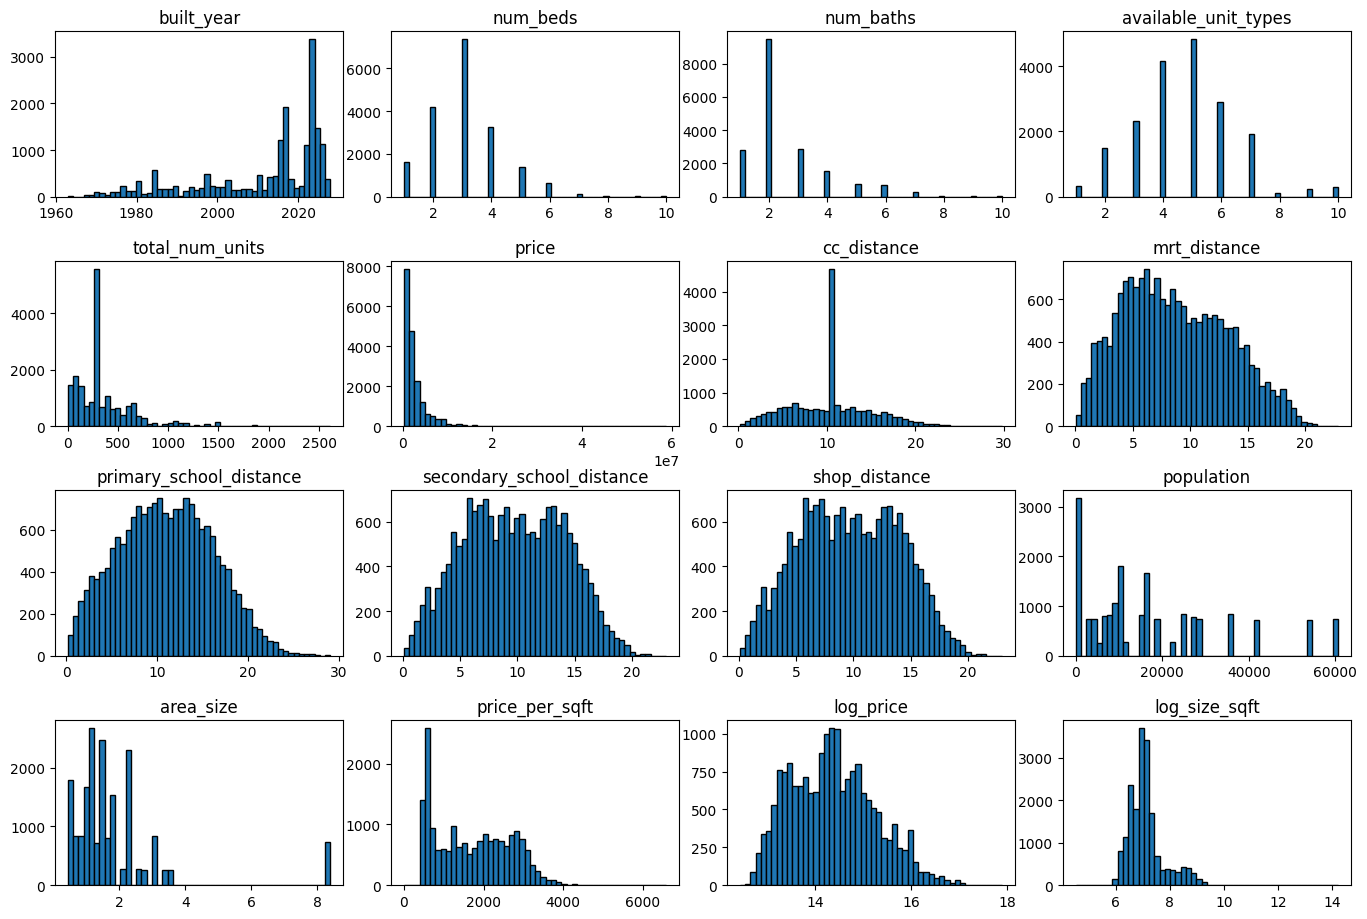

In [87]:
train['log_size_sqft'] = np.log(train['size_sqft'])
plot_train = train.drop(columns=['size_sqft'])
plot_train.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

#### Planning_area ~ price

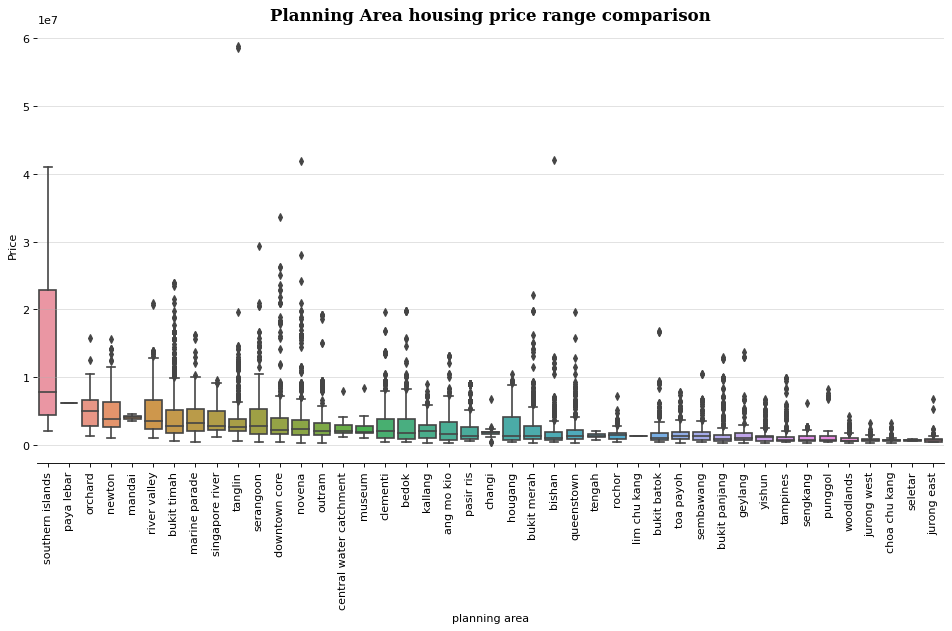

In [88]:
# Visualization
fig, ax = plt.subplots(1,1, figsize=(12, 8), dpi=80)

# Find the order
my_order = train.groupby(by=["planning_area"])["log_price"].mean().sort_values(ascending=False).index

box_plot = sns.boxplot(x = 'subzone',y = 'price',data = train, order=my_order)
plt.ylabel('Price')
plt.xlabel('planning area')
plt.title('Planning Area housing price range comparison', fontsize=15, fontweight='bold', fontfamily='serif')

ax = box_plot.axes

lines = ax.get_lines()
#categories = ax.get_xticks()
ax.tick_params(axis='x', rotation=90)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.4) 

box_plot.figure.tight_layout()

#fig = box_plot.get_figure()

#### Coorelation Matrix

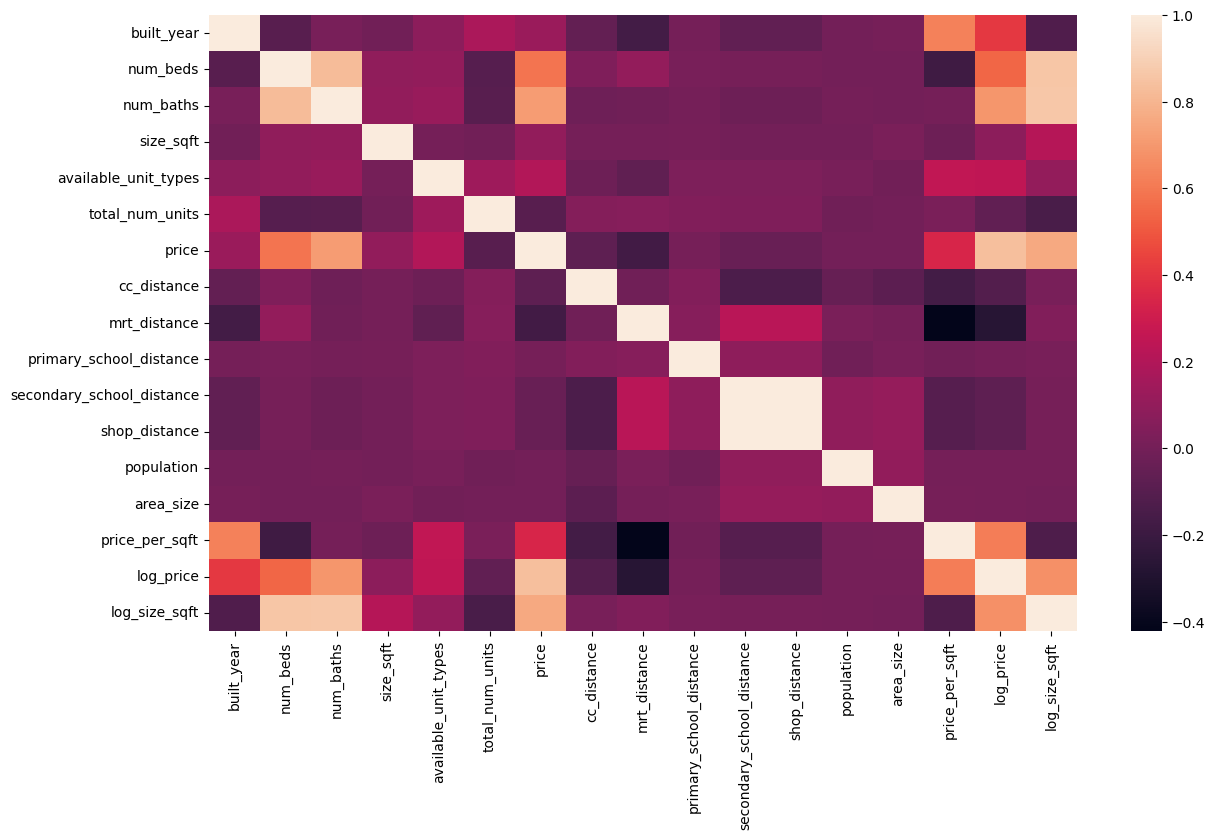

In [89]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr())
plt.show()

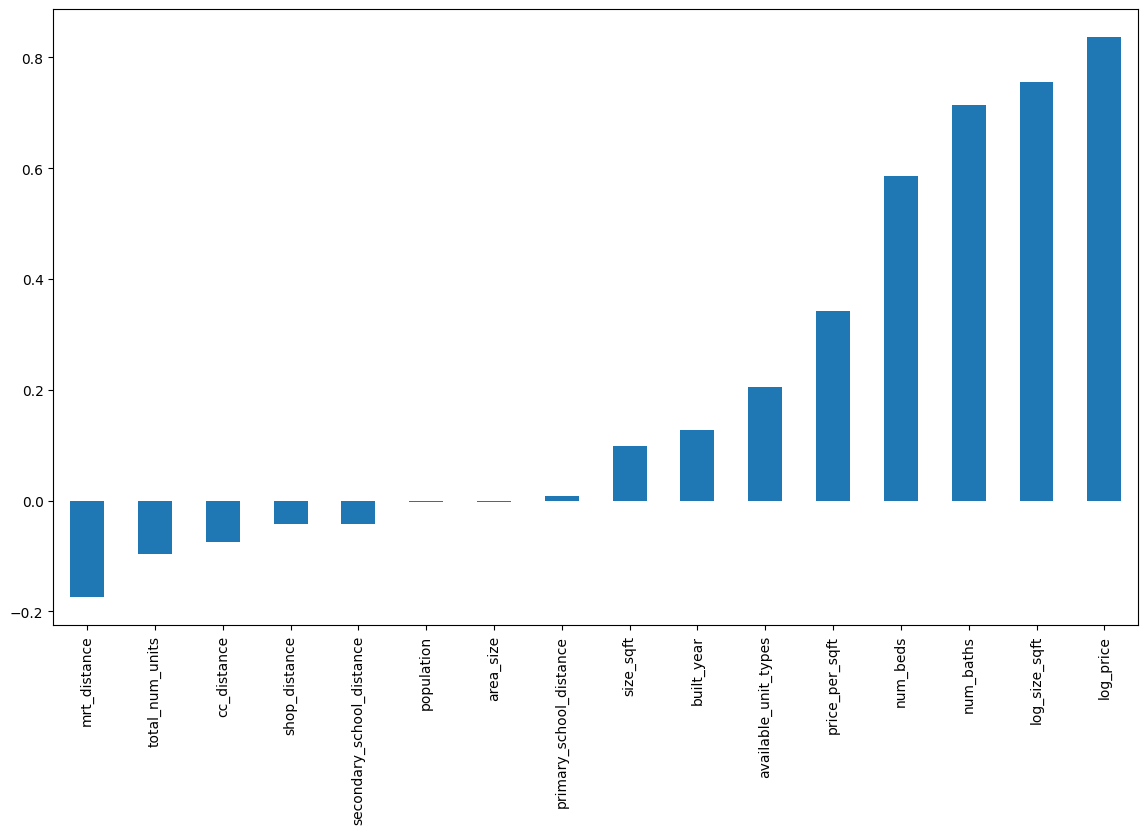

In [90]:
plt.figure(figsize=(14,8))
train.corr()['price'].sort_values()[:-1].plot(kind='bar')
plt.show()

#### Year Built ~ Price

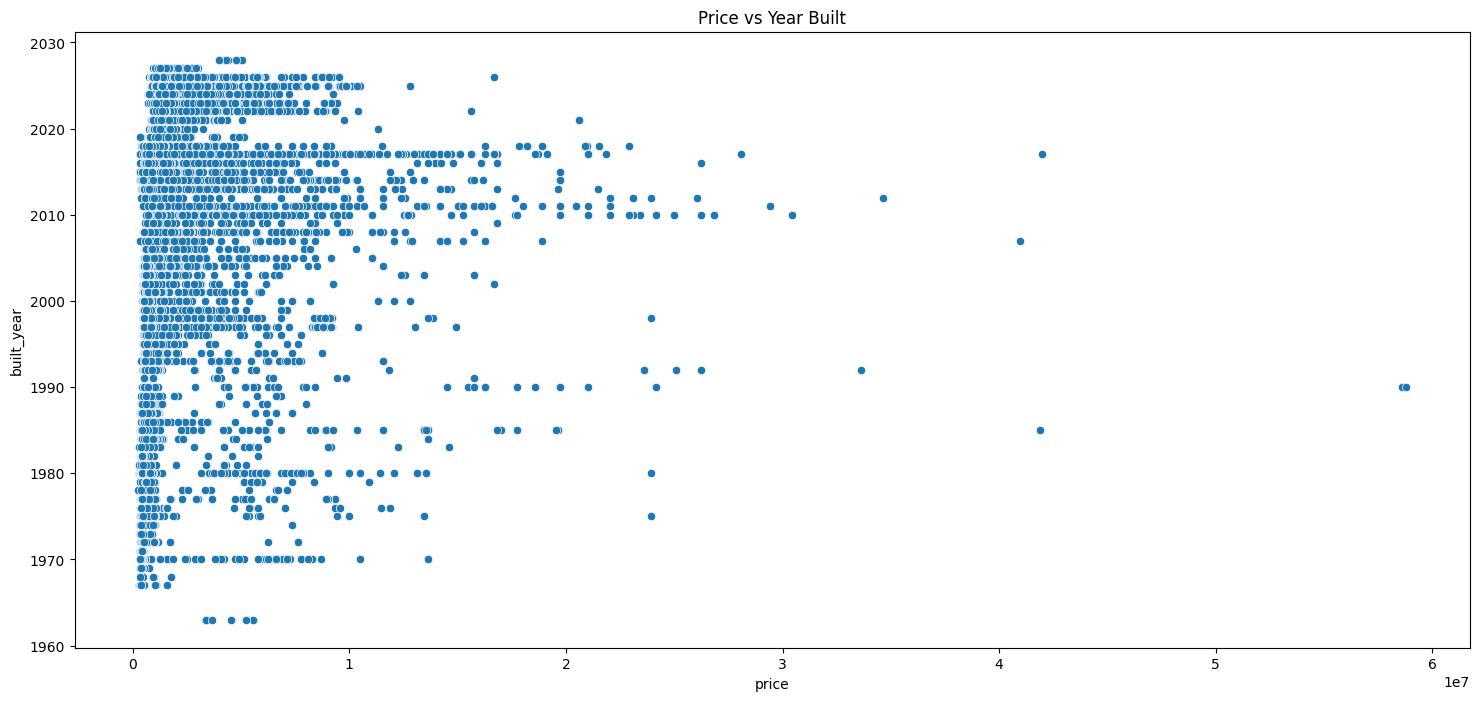

In [91]:
fig, axes = plt.subplots(figsize=(18,8))
sns.scatterplot(x ='price', y= 'built_year', data=train)
axes.set_title('Price vs Year Built')
plt.show()

### property_type ~ price

/var/folders/qn/qbbz_vys3cdbcvx4l1kc4xf00000gn/T/ipykernel_45631/2196547569.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


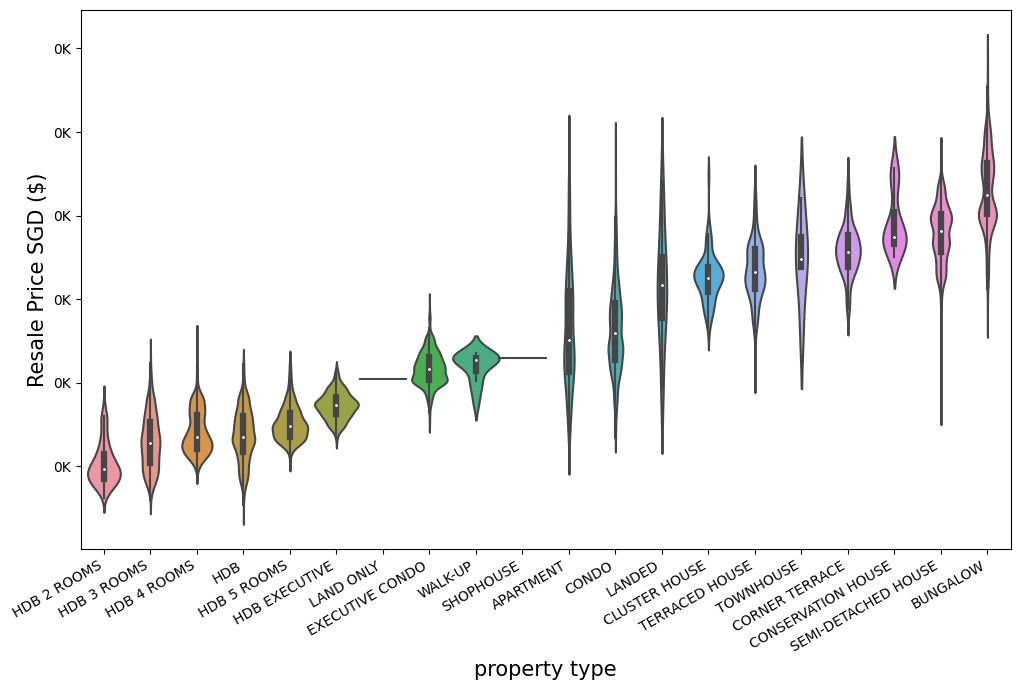

In [92]:
# Violin plots for price distribution of each flat model

fig = plt.figure(figsize=(12,7))
p=sns.violinplot(x='property_type', y='log_price', data=train, width=1,
                order=train.groupby('property_type')['price'].median().sort_values().reset_index()['property_type'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right'), p.set_xlabel('property type', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
plt.show()

In [93]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,subzone,...,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,log_price,log_size_sqft
1,HDB,99-year leasehold,1992,4,2,1575,unfurnished,6,296,serangoon,...,2.400374,6.871207,8.310177,6.710202,6.710202,18660,8.4055,632.000000,13.810900,7.362011
2,CONDO,freehold,2022,4,6,3070,partial,5,56,marine parade,...,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,2763.843648,15.953810,8.029433
3,CONDO,freehold,2023,3,2,958,partial,5,638,bukit timah,...,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,2741.127349,14.780972,6.864848
4,CONDO,99-year leasehold,2026,2,1,732,unfurnished,6,351,downtown core,...,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,2409.836066,14.383095,6.595781
5,CONDO,freehold,2024,2,2,689,unfurnished,6,633,bukit batok,...,12.115573,8.822150,9.964453,11.837034,11.837034,2620,0.4364,2470.246734,14.347315,6.535241


#### Price ~ Distance

/var/folders/qn/qbbz_vys3cdbcvx4l1kc4xf00000gn/T/ipykernel_45631/3630420851.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)


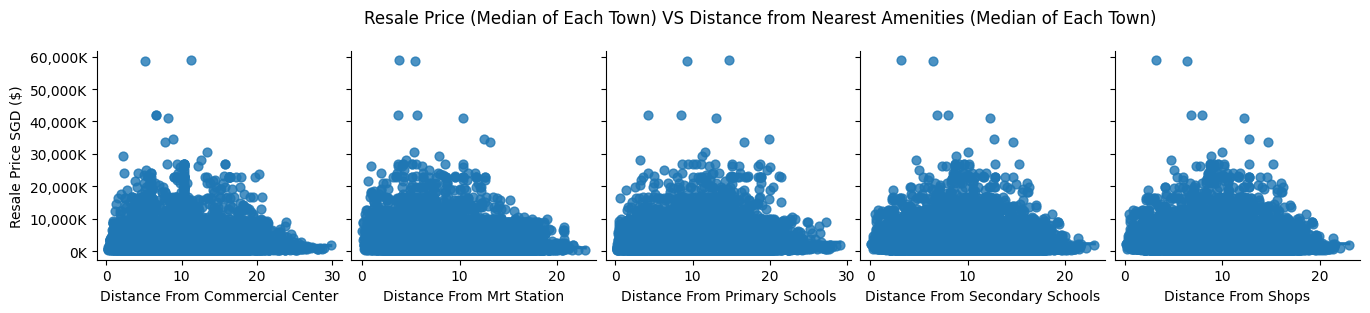

In [94]:
p=sns.pairplot(train, x_vars=["cc_distance", "mrt_distance", "primary_school_distance", "secondary_school_distance", "shop_distance"], y_vars=["price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Distance From Commercial Center', size=10), axes[0,1].set_xlabel('Distance From Mrt Station', size=10)
axes[0,2].set_xlabel('Distance From Primary Schools', size=10), axes[0,3].set_xlabel('Distance From Secondary Schools', size=10)
axes[0,4].set_xlabel('Distance From Shops', size=10),
plt.suptitle('Resale Price (Median of Each Town) VS Distance from Nearest Amenities (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

# Mining

#### Conforming Test and Train to be the same

In [95]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,available_unit_types,total_num_units,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,price_per_sqft,log_price,log_size_sqft
count,18540.000000,18540.000000,18540.000000,1.854000e+04,18540.000000,18540.000000,1.854000e+04,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000,18540.000000
mean,2011.562999,3.065264,2.562945,1.747449e+03,4.721359,361.546710,2.631254e+06,10.298632,8.703711,10.982043,9.687485,9.687485,17070.980583,1.794979,1707.598336,14.364246,7.107235
std,15.374687,1.242899,1.391442,1.409815e+04,1.687274,297.504167,3.048773e+06,4.654233,4.535822,5.176569,4.343343,4.343343,16224.927127,1.528548,936.740306,0.881245,0.654253
min,1963.000000,1.000000,1.000000,9.200000e+01,1.000000,4.000000,2.508000e+05,0.166654,0.027288,0.163496,0.097494,0.097494,0.000000,0.436400,1.049958,12.432411,4.521789
25%,2002.000000,2.000000,2.000000,7.970000e+02,4.000000,160.000000,8.400000e+05,6.971968,5.050721,7.091899,6.222268,6.222268,4370.000000,1.061900,731.442614,13.641157,6.680855
50%,2017.000000,3.000000,2.000000,1.108000e+03,5.000000,296.000000,1.674700e+06,10.324064,8.258901,10.904891,9.605643,9.605643,10840.000000,1.432900,1668.625197,14.331145,7.010312
75%,2023.000000,4.000000,3.000000,1.475000e+03,6.000000,455.000000,3.087525e+06,12.922543,12.166360,14.765006,13.172567,13.172567,24760.000000,2.206800,2511.403657,14.942880,7.296413
max,2028.000000,10.000000,10.000000,1.496000e+06,10.000000,2612.000000,5.880000e+07,29.798731,22.877877,29.078982,22.989355,22.989355,60670.000000,8.405500,6585.123967,17.889652,14.218305


In [123]:
X_train_raw = train.drop(columns=['price','log_price','log_size_sqft','price_per_sqft','subzone'])
y_train_raw = train['price']

X_test_raw = test.drop(columns='subzone')

In [129]:
#Regression Task
X_train_raw = pd.get_dummies(X_train_raw)

In [130]:
X_test_raw = pd.get_dummies(X_test_raw)

#### Building and evaluating model

In [131]:
import xgboost as xgb 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score


In [138]:
# define model
model = xgb.XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_raw, y_train_raw, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 267330.630 (13717.156)


In [140]:
model.fit(X_train_raw,y_train_raw)
model.predict(X_test_raw)

array([1224898.4 , 1828241.2 , 1397426.1 , ..., 3279151.8 ,  968077.25,
       3282166.8 ], dtype=float32)

### Random Forest

In [144]:
from random import random
from sklearn.ensemble import RandomForestRegressor
rf_grid_parameters = [
    { # Tree
        'n_estimators': list(range(50,300,50)), 
        'criterion': ['squared_error','absolute_error','poisson'],
        'max_depth': list(range(1,10,1)),
        'min_samples_split': list(range(2,10,2)),
        'min_samples_leaf': list(range(1,5,1)),
        'max_features': ['sqrt', 'log2'],
    },
]

regressor = RandomForestRegressor()
dt_grid = GridSearchCV(estimator=regressor, param_grid=rf_grid_parameters, cv=cv ,scoring='neg_root_mean_squared_error')

# fitting the model for grid search
dt_grid_search=dt_grid.fit(X_train_raw, y_train_raw)